# Geochemistry - Automated ML Clustering 

## using pycaret framework


Hierarchical clustering of XRF geochemistry with constraint.

+ Features
    + Custom geochemistry dataframe I/O
    + Automated ML framework built on PyCaret
    + Depth constraints for hierarchical clusters 
    + Visualization / interpretation utilities 

N.C. Howes   
November 2021

## Configuration

Load custom geochemistry module from digital-core package. 

In [31]:
import sys, os 
sys.path.append("..")

#For development 
%reload_ext autoreload
%autoreload 2

In [32]:
from digitalcore import GeochemML

Read sample geochemistry data from csv. OOLDEA2 core from South Australia. 

In [33]:
#Input path 
filepath = '../data/OOLDEA2_1m_intervals.csv'

# Output path
fullpath_to_product = '../data/data-products/OOLDEA2_1m_intervals-labeled.csv'



## Workflow

In [34]:
this = GeochemML.read_csv( filepath )

Custom geochemistry dataframe provides convenience methods for: preview, visualization, and feature mapping. We'll preview the header, plot an element series, and list the subset of variables that are used as features in the clustering analysis. To see a list of masked or "ignored" variables, call `this.get_ignorefeatures()`. These are used for visualization and interpretation, but not the model fits. By default all metadata, depth, mdl, and 2SE variables are omitted.  

View the first 5 rows/instances, use `this.tail()` to view the last n rows. 

In [35]:
this.head()

,id,result_master_id,DDH_name,from_m,to_m,Sample_Length_m,Scan_Length_m,Scan_Recovery_pct,Comp(c/s),Rayl(c/s),...,Ce_ppm,Ce_2SE_ppm,Ce_mdl_ppm,Pb_pct,Pb_2SE_pct,Pb_mdl_pct,U_ppm,U_2SE_ppm,U_mdl_ppm,minaloggerlink
0,69232,38,OOLDEA2,13,14,1,0.2401,24.01,2613.187,715.3073,...,87.31,54.90,40.99,0.0029,0.0017,0.0025,22.97,15.03,20.40,https://minalogger.com/viewer/?project=WESTERN...
1,69233,38,OOLDEA2,14,15,1,0.4056,40.56,2498.827,653.7424,...,70.23,45.22,36.78,0.0030,0.0014,0.0021,20.18,12.16,16.75,https://minalogger.com/viewer/?project=WESTERN...
2,69234,38,OOLDEA2,15,16,1,0.6329,63.29,2869.263,702.2439,...,113.00,36.45,30.90,0.0032,0.0012,0.0019,31.67,10.89,14.70,https://minalogger.com/viewer/?project=WESTERN...
3,69235,38,OOLDEA2,16,17,1,0.6143,61.43,2594.439,641.5786,...,73.96,29.13,24.85,0.0036,0.0010,0.0015,24.23,9.12,12.22,https://minalogger.com/viewer/?project=WESTERN...
4,69236,38,OOLDEA2,17,18,1,0.4486,44.86,2578.841,647.0553,...,94.63,28.67,26.67,0.0039,0.0011,0.0016,22.88,10.39,13.37,https://minalogger.com/viewer/?project=WESTERN...


Plot an element series

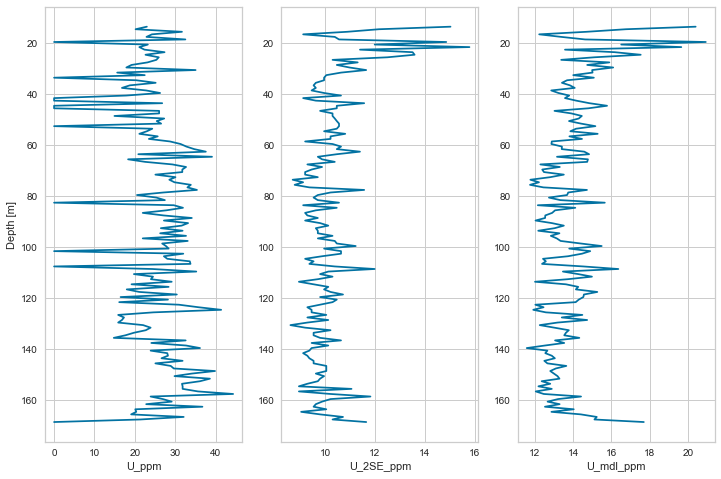

In [36]:
this.plot_element( "U" )

List features used for fit... 

In [37]:
features = this.get_features()
print( features )
print( len(features) )

['Cr_ppm', 'Pb_pct', 'Ti_ppm', 'Ba_ppm', 'P_ppm', 'Si_pct', 'V_ppm', 'K_pct', 'Zn_pct', 'As_ppm', 'Sr_ppm', 'Se_ppm', 'Zr_ppm', 'Fe_pct', 'Mn_ppm', 'La_ppm', 'Ga_ppm', 'U_ppm', 'Y_ppm', 'S_pct', 'Ca_pct', 'Cl_ppm', 'Rb_ppm', 'Nb_ppm', 'Mo_ppm', 'Al_pct', 'Ni_ppm', 'Cu_pct', 'Ce_ppm']
29


## Prepare experiment 

Specify the **data preparation** parameters to be used for the experiment.   

Parameters to explore include:
+ Feature scaling/normalization: zscore, minmax 
+ Dimension reduction: principal component analysis, etc... 


It also possible to pass a custom preparation pipeline as an input option. See the PyCaret documentation on cluster setup for more options: [PyCaret Cluster Setup](https://pycaret.readthedocs.io/en/latest/api/clustering.html)

In [38]:
this.dataopts = dict(
    normalize=True,
    )

this.prepare( silent=True )

,Description,Value
0,session_id,123
1,Original Data,"(156, 99)"
2,Missing Values,False
3,Numeric Features,29
4,Categorical Features,0
5,Ordinal Features,False
6,High Cardinality Features,False
7,High Cardinality Method,None
8,Transformed Data,"(156, 29)"
9,CPU Jobs,-1


## Prepare models


Review a list available cluster models.  

In [39]:
this.get_listmodels()

,Name,Reference
ID,,
kmeans,K-Means Clustering,sklearn.cluster._kmeans.KMeans
ap,Affinity Propagation,sklearn.cluster._affinity_propagation.Affinity...
meanshift,Mean Shift Clustering,sklearn.cluster._mean_shift.MeanShift
sc,Spectral Clustering,sklearn.cluster._spectral.SpectralClustering
hclust,Agglomerative Clustering,sklearn.cluster._agglomerative.AgglomerativeCl...
dbscan,Density-Based Spatial Clustering,sklearn.cluster._dbscan.DBSCAN
optics,OPTICS Clustering,sklearn.cluster._optics.OPTICS
birch,Birch Clustering,sklearn.cluster._birch.Birch
kmodes,K-Modes Clustering,kmodes.kmodes.KModes


Specify the **model types** to be used for the experiment. Customize model parameters by assigning a dictionary to the `modelopts` attribute, otherwise the models will run with default parameter settings. The modelopts are global parameters and are applied to all cluster models in the experiment.

All agglomerative cluster models are depth/strat constrained. 

Parameters to explore include:
+ k-means
    + n-clusters
+ agglomerative clustering
    + linkage method
    + dissimilarity metric 
    + linkage threshold

In [40]:
# Add models. Specify as a list 
this.name = ["hclust"]

# Add optional model configuration. 
this.modelopts = dict( num_clusters = 3 )

In [41]:
this.modelopts

{'num_clusters': 3}


Fit a cluster model or array of models (autoML)

In [42]:
this.create()

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.1775,17.8073,2.1288,0,0,0


### Assign labels

After fitting the models, we append vluster labels to the end of the dataframe

In [43]:
this.label()

In [44]:
this.data.iloc[10:18, [0,1,2,-2,-1] ]

,id,result_master_id,DDH_name,minaloggerlink,hclust_Cluster
10,69242,38,OOLDEA2,https://minalogger.com/viewer/?project=WESTERN...,Cluster 0
11,69243,38,OOLDEA2,https://minalogger.com/viewer/?project=WESTERN...,Cluster 0
12,69244,38,OOLDEA2,https://minalogger.com/viewer/?project=WESTERN...,Cluster 0
13,69245,38,OOLDEA2,https://minalogger.com/viewer/?project=WESTERN...,Cluster 0
14,69246,38,OOLDEA2,https://minalogger.com/viewer/?project=WESTERN...,Cluster 0
15,69247,38,OOLDEA2,https://minalogger.com/viewer/?project=WESTERN...,Cluster 0
16,69248,38,OOLDEA2,https://minalogger.com/viewer/?project=WESTERN...,Cluster 0
17,69249,38,OOLDEA2,https://minalogger.com/viewer/?project=WESTERN...,Cluster 0


## Evaluate results

In [45]:
this.active = 0
this.get_activemodel()


'hclust_Cluster'

### Cluster PCA Plot (2d)  

In [46]:
this.plottype = "cluster"
this.plotmodel()

### Cluster TSnE (3d)

In [47]:
if this.get_activemodel() != "hclust_Cluster":
    this.plottype = "tsne"
    #this.plotmodel()

### Elbow Plot

In [48]:
if this.get_activemodel() != "hclust_Cluster":
    this.plottype = "elbow"
    this.plotmodel()

### Distance Plot

In [49]:
this.plottype = "distance"
#this.plotmodel()

### Distribution Plot

In [50]:
this.plottype = "distribution"
this.plotmodel()

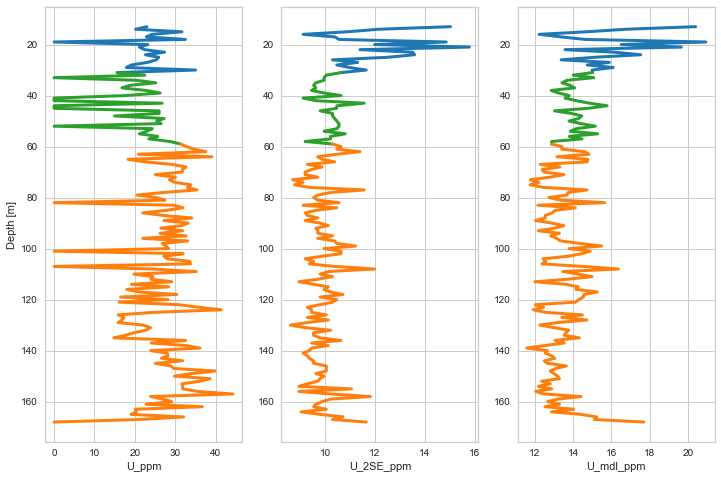

In [51]:
this.plot_element( "U", labels=True )

## Interpretation 

Aggregate element statistics by cluster.

In [52]:
df = this.aggregate( output="unstack" )
df

hclust_Cluster,element,cluster 0,cluster 1,cluster 2,type
0,Al_pct median,4.33055,4.7494,5.90025,pct
1,Ca_pct median,2.23275,0.7056,1.0129,pct
2,Cu_pct median,0.004,0.0049,0.0048,pct
3,Fe_pct median,8.24355,12.35935,14.6473,pct
4,K_pct median,2.0581,1.71665,1.9208,pct
5,Pb_pct median,0.001,0.0,0.0,pct
6,S_pct median,0.1504,0.0,0.0,pct
7,Si_pct median,19.42075,21.3501,25.1516,pct
8,Zn_pct median,0.0051,0.005,0.0074,pct
9,As_ppm median,0.0,8.285,11.825,ppm


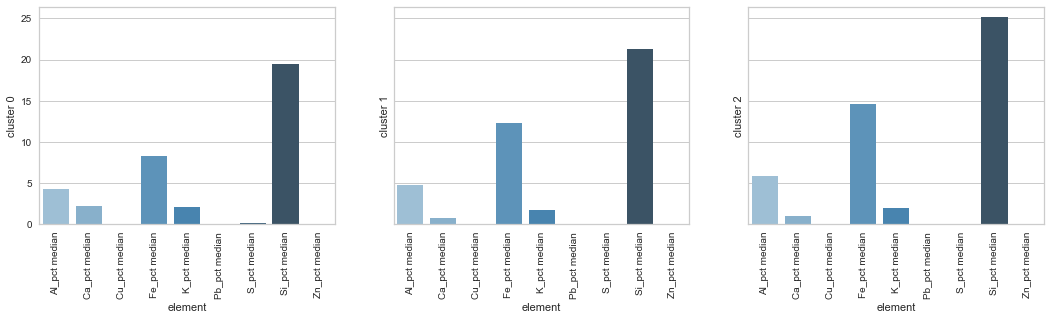

In [53]:
this.plot_aggregates( by="cluster", type="pct" )

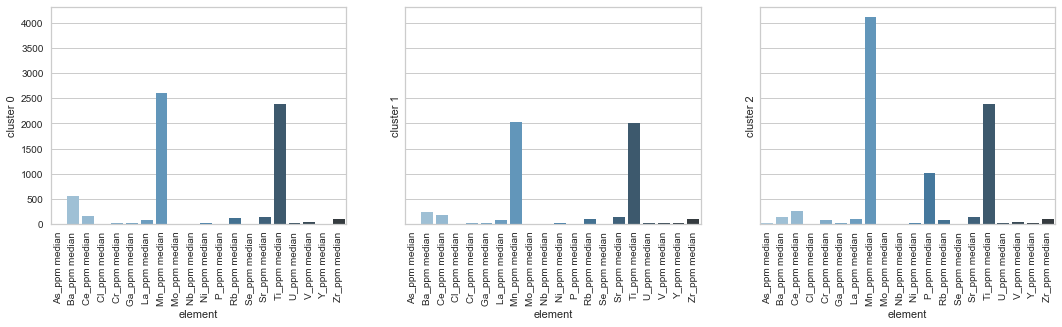

In [54]:
this.plot_aggregates( by="cluster", type="ppm" )

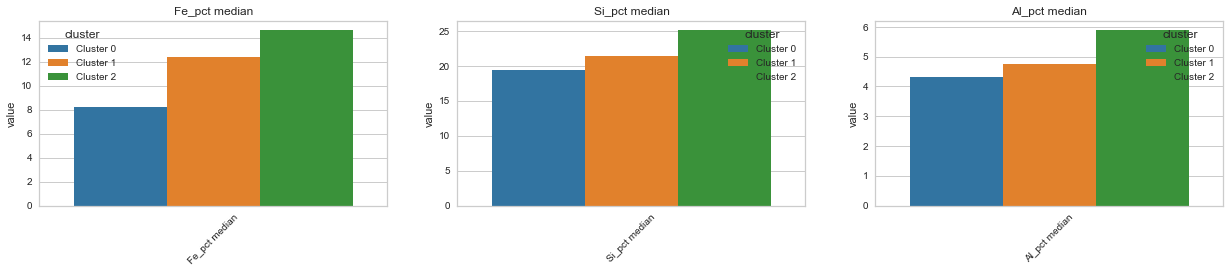

In [55]:
this.plot_aggregates( by="feature", type="pct" )

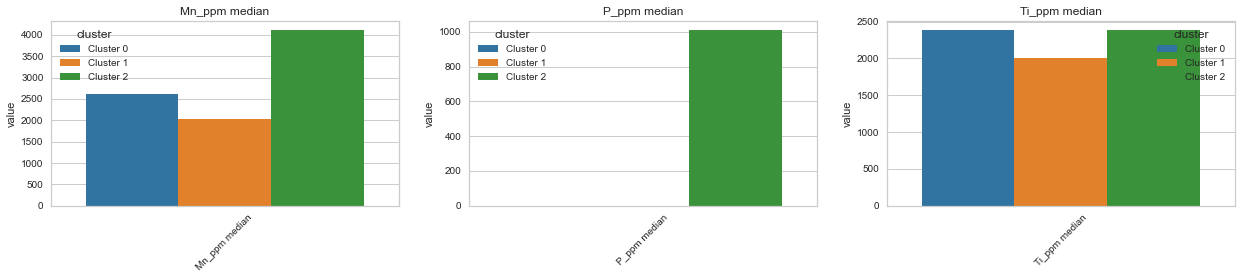

In [56]:
this.plot_aggregates( by="feature", type="ppm" )

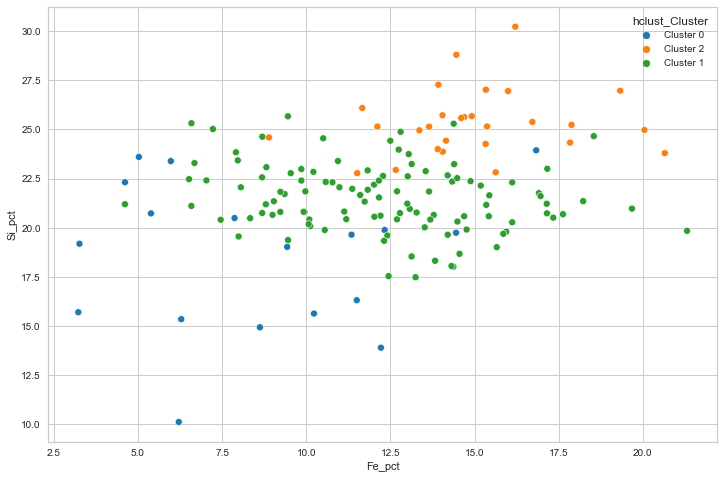

In [57]:
this.plot_scatter("Fe", "Si")

## Export

Save/write to disk. 

In [58]:
this.data.to_csv(fullpath_to_product, index=False)